# Implémenter un modèle de scoring

## Exploration de données 
 
**I) Preprocessing **
**
- I.1 <a href="#C1"> Kernel Kaggle </a> 
- I.1 <a href="#C1_bis"> Analyse exploratire </a> 

**Partie II : Modélisation **
**
- II.1 <a href="#C2">Cross validation </a>
- II.2 <a href="#C3">Détermination des meilleurs hyperparamètres </a>
- II.3 <a href="#C4"> Pipeline associés aux différents modèles</a>
- II.4 <a href="#C5">Prédiction calul des performances</a>


**Partie III : Métriques  **
- III.1 <a href="#C6">Détermination du seuil </a>
- III.2 <a href="#C7">Courbe R.O.C</a>

**Partie IV : Feature importance  **

- IV.1 <a href="#C8">Feature importance global</a>
- IV.2 <a href="#C9">Feature importance local</a>

**Partie V : API  **
- V.<a href="#C10">Préparation des données pour l'api </a>


## I) Preprocessing 

###  <a name="C1"> I.1 - kernel Kaggle</a> 

In [1]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

import re
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import precision_recall_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV 
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import joblib
import shap


@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    
    """ On utilise la foncrion One Hot Encoding pour changer les variables catégoriques en variables numériques.
    Pour ce faire on utilise la fonction get Dummies """
    
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    
    """ Dans cette fonction on effectue des étapes de preprocessing, on crée des variabels en fonction 
    d'autres variables. On utilise One Hot Encoder afin de rendre nuémerique des variales catégoriques binaires """
    
    # Read data and merge
    df = pd.read_csv('input/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('input/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    
    # free memory space
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    
    """  """
    
    bureau = pd.read_csv('input/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('input/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('input/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('input/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('input/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('input/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
    
    # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

In [2]:
num_rows = 10000
df = application_train_test(num_rows)
with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
with timer("Process previous_applications"):
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')

pos = pos_cash(num_rows)
print("Pos-cash balance df shape:", pos.shape)
df = df.join(pos, how='left', on='SK_ID_CURR')

    
ins = installments_payments(num_rows)
print("Installments payments df shape:", ins.shape)
df = df.join(ins, how='left', on='SK_ID_CURR')
del ins

cc = credit_card_balance(num_rows)
print("Credit card balance df shape:", cc.shape)
df = df.join(cc, how='left', on='SK_ID_CURR')
del cc


train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.fillna(0, inplace=True)
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.fillna(0, inplace=True)
train_df = train_df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
test_df = test_df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

del df

f_score = dict()
lim = dict()
feats = [f for f in train_df.columns if f not in [
    'TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]
np.savetxt("feats.csv", np.atleast_2d(feats), fmt="%s", delimiter=",")


test_df.to_pickle("test_df.gz", compression={
                  'method': 'gzip', 'compresslevel': 1, 'mtime': 1})

Train samples: 10000, test samples: 10000
Bureau df shape: (2011, 108)
Process bureau and bureau_balance - done in 1s
Previous applications df shape: (9734, 242)
Process previous_applications - done in 1s
Pos-cash balance df shape: (9494, 15)
Installments payments df shape: (8893, 26)
Credit card balance df shape: (9520, 131)



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


###  <a name="C1_bis"> I.1 - Analyse exploratoire</a> 

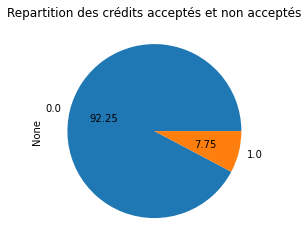

In [3]:
train_df.groupby('TARGET').size().plot.pie( y="credit scoring" , autopct='%.2f')
plt.title('Repartition des crédits acceptés et non acceptés')

plt.show()

- Nous obtenons 92% de crédit acceptés cont 8% de crédit non acceptés

# II) Modélisation 

## <a name="C2"> II.1 - Cross validation </a> 

In [4]:
def cross_val(train_df,feats,n_folds):
    
    """ Cette fonction est utilisé pour effectuer la cross-validation des données train.
    On split le train set en n_folds. Cela permet de prevenir le problème d'overfitting """
    
    folds = KFold(n_splits= n_folds, shuffle=True, random_state=1001)
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
    return  folds,train_x,train_y,valid_x,valid_y,valid_idx

## <a name="C3"> II.2 - Détermination des meilleurs hyperparamètres </a> 

In [5]:
def best_params_knn():   
    knn = KNeighborsClassifier()
    over = SMOTE(sampling_strategy=0.2)
    
    under = RandomUnderSampler(sampling_strategy = 0.5)
    
    steps = [("over", over), ("under", under), ("model", knn)]
    knn_pipe = Pipeline(steps=steps)

    params = [{"model__n_neighbors" : [4, 5, 6, 7, 8, 9],
              "model__algorithm" : ["ball_tree", "kd_tree"], 
              "model__n_jobs" : [6]}]

    gs_knn = GridSearchCV(knn_pipe,param_grid = params,scoring = "roc_auc",cv=5)
    gs_knn.fit(train_df[feats], train_df['TARGET'])
    param = gs_knn.best_params_
    return param 


def best_params_lgbm():   
    lgbm = LGBMClassifier()
    over = SMOTE(sampling_strategy=0.2)
    under = RandomUnderSampler(sampling_strategy = 0.5)
    steps = [("over", over), ("under", under), ("model", lgbm)]
    lgbm_pipe = Pipeline(steps=steps)

    params = [{"model__n_estimators" : [100, 1000, 10000],
              "model__learning_rate" : [0.001, 0.01, 0.1], 
              "model__num_leaves" : [20, 30, 40]}]

    gs_lgbm = GridSearchCV(lgbm_pipe,param_grid = params,scoring = "roc_auc",cv=5)

    gs_lgbm.fit(train_df[feats], train_df['TARGET'])
    param = gs_lgbm.best_params_
    return param


def best_params_rf():   
    rf =  RandomForestClassifier()
    over = SMOTE(sampling_strategy=0.2)
    under = RandomUnderSampler(sampling_strategy = 0.5)
    steps = [("over", over), ("under", under), ("model", rf)]
    rf_pipe = Pipeline(steps=steps)

    params = [{"model__n_estimators" : [10, 100, 1000],
                  "model__max_features" : ["sqrt", "log2"], 
                  "model__n_jobs" : [6]}]

    gs_rf = GridSearchCV(rf_pipe,param_grid = params,scoring = "roc_auc",cv=5)

    gs_rf.fit(train_df[feats], train_df['TARGET'])
    param = gs_rf.best_params_
    return param 

def best_params_xg():   
    xg =  GradientBoostingClassifier()
    over = SMOTE(sampling_strategy=0.2)
    under = RandomUnderSampler(sampling_strategy = 0.5)
    steps = [("over", over), ("under", under), ("model", xg)]
    xg_pipe = Pipeline(steps=steps)

    params =  {#"loss":["deviance"],
    "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "model__max_depth":[3,5],
    "model__max_features":["log2","sqrt"],
    "model__criterion": ["friedman_mse",  "mse"],
    #"subsample":[0.5, 0.85, 1.0],
    "model__n_estimators":[10,50,100]
    }
    
    gs_xg = GridSearchCV(xg_pipe ,param_grid = params,scoring = "roc_auc",cv=5)
    gs_xg.fit(train_df[feats], train_df['TARGET'])
    param = gs_xg.best_params_
    return param 

def best_params_svc():
    svc = SVC()
    over = SMOTE(sampling_strategy=0.2)
    under = RandomUnderSampler(sampling_strategy = 0.5)
    
    # On rajoute la standardisation et la réduction via la méthode StandardScaler de la class preprocessing
    
    steps = [("over", over), ("under", under), ("scaler",StandardScaler()), ("model", svc)]
    svc_pipe = Pipeline(steps=steps)
    
    params = {'model__C': [1, 10], 
              'model__gamma': [1,0.1],
              'model__kernel': ['rbf', 'poly']}
        
    svc = GridSearchCV(svc_pipe ,param_grid = params,scoring = "roc_auc",cv=5)
    svc.fit(train_df[feats], train_df['TARGET'])
    param = svc.best_params_
    return param 

In [6]:
#bst_para_rf = best_params_rf()

In [7]:
#bst_para_lgbm = best_params_lgbm()

In [8]:
#bst_para_knn = best_params_knn

In [9]:
#best_params_xg()

#{'model__criterion': 'mse','model__learning_rate': 0.05,'model__max_depth': 3,'model__max_features': 'sqrt','model__n_estimators': 100}

In [10]:
# best_params_lnr_ridge() {'model__alpha': 0.1, 'model__normalize': False, 'model__solver': 'lsqr'}

In [11]:
# bst_para_svc = best_params_svc() {'model__C': 10, 'model__gamma': 0.1, 'model__kernel': 'poly'}

## <a name="C4"> II.3 - Pipeline associés aux différents modèles </a> 

In [12]:
def random_forest(train_x,train_y):
    
    """  """
    
    rfc1=RandomForestClassifier(random_state=42, max_features='sqrt', n_estimators= 1000, n_jobs = 6) 
    over = SMOTE(sampling_strategy=0.2)
    # tchecker RandomUnderSampler
    under = RandomUnderSampler(sampling_strategy = 0.5)
    steps = [("over", over), ("under", under), ("model", rfc1)]
    rf_pip = Pipeline(steps=steps)
    rf_pip.fit(train_x, train_y)
    return rf_pip

def lgbm(train_x,train_y):
    
    """  """
    
    clf_lgb = LGBMClassifier(learning_rate = 0.01, n_estimators= 1000, num_leaves= 20)
    over = SMOTE(sampling_strategy=0.2)
    under = RandomUnderSampler(sampling_strategy = 0.5)
    steps = [("over", over), ("under", under), ("model", clf_lgb)]
    lgbm_pip = Pipeline(steps=steps)
    lgbm_pip.fit(train_x, train_y, model__eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            model__eval_metric= "auc", model__verbose= 200, model__early_stopping_rounds= 200)
    return lgbm_pip

def knn(train_x,train_y):
    
    """  """
    
    knn = KNeighborsClassifier(algorithm = 'ball_tree', n_jobs= 6, n_neighbors = 1)
    over = SMOTE(sampling_strategy=0.2)
    under = RandomUnderSampler(sampling_strategy = 0.5)
    steps = [("over", over), ("under", under), ("model", knn)]
    knn_pip = Pipeline(steps=steps)
    knn_pip.fit(train_x, train_y)
    return knn_pip

def loglin(train_x,train_y):
    """  """
    
    log_lin = LogisticRegression(n_jobs = 6, max_iter = 5000)
    over = SMOTE(sampling_strategy=0.2)
    under = RandomUnderSampler(sampling_strategy = 0.5)
    steps = [("over", over), ("under", under), ("model", log_lin)]
    log_pip = Pipeline(steps=steps)
    log_pip.fit(train_x, train_y)
    return log_pip


def xgboost(train_x,train_y):
    """ Cette fonction prend en entrée les données d'entrainements du dataset et renvoie la pipeline contenant le modèle
    de gradiant boosting avec les meilleurs hyperparamètres. 
    n_estimators=100
    learning_rate=0.05
    max_depth=3
    max_features='sqrt'
    criterion="mse"
    """
    
    xgboost = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05,max_depth=3, max_features='sqrt', criterion="mse")
    over = SMOTE(sampling_strategy=0.2)
    under = RandomUnderSampler(sampling_strategy = 0.5)
    steps = [("over", over), ("under", under), ("model", xgboost)]
    xgboost_pip = Pipeline(steps=steps)
    xgboost_pip.fit(train_x, train_y)
    return xgboost_pip

def svc(train_x,train_y):
    """  """
    
    svc = SVC(C = 100, gamma = 0.1, kernel = 'poly', probability = True)
    over = SMOTE(sampling_strategy=0.2)
    under = RandomUnderSampler(sampling_strategy = 0.5)
    steps = [("over", over), ("under", under), ("scaler",StandardScaler()), ("model", svc)]
    svc_pip = Pipeline(steps=steps)
    svc_pip.fit(train_x, train_y)
    return svc_pip

In [13]:
cv_folds,train_x,train_y,valid_x,valid_y,valid_idx = cross_val(train_df,feats,n_folds = 6)

rf_pipe = random_forest(train_x,train_y)

lgbm_pipe = lgbm(train_x,train_y)

knn_pipe = knn(train_x,train_y)

loglin_pipe = loglin(train_x,train_y)

Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.837387	valid_0's binary_logloss: 0.313604	valid_1's auc: 0.708368	valid_1's binary_logloss: 0.326673
[400]	valid_0's auc: 0.898919	valid_0's binary_logloss: 0.260112	valid_1's auc: 0.714762	valid_1's binary_logloss: 0.293795
[600]	valid_0's auc: 0.934916	valid_0's binary_logloss: 0.230923	valid_1's auc: 0.721418	valid_1's binary_logloss: 0.282312
[800]	valid_0's auc: 0.955515	valid_0's binary_logloss: 0.210867	valid_1's auc: 0.721699	valid_1's binary_logloss: 0.277444
Early stopping, best iteration is:
[738]	valid_0's auc: 0.949905	valid_0's binary_logloss: 0.216638	valid_1's auc: 0.722217	valid_1's binary_logloss: 0.278607


In [14]:
xgboost_pipe = xgboost(train_x,train_y)

In [15]:
scv_pipe = svc(train_x,train_y)

## <a name="C5"> II.4 - Prédiction calul des performances </a> 

In [16]:
def prediction(pipeline , train_df, n_folds,  cv_fold , valid__x , valid__y , valid__idx): 
    
    """ Cette fonction donne pour un algorithme donné le score AUC d'un algorithme de machine learning
    pour ce faire nous avons juste besoin de la pipeline de l'algorithme de classification """
    
    oof_preds = np.zeros(train_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

    # prediction
  
    oof_preds[valid__idx] = pipeline.predict_proba(valid__x)[:, 1]
    #sub_preds += pipeline.predict_proba(test_df[feats])[:, 1] / n_fold.n_splits

    # metrique pour le score 
    print('Fold %2d AUC : %.6f' % (n_folds, roc_auc_score(valid__y, oof_preds[valid__idx])))
    return roc_auc_score(valid__y, oof_preds[valid__idx]) , oof_preds[valid__idx]


In [17]:
lgbm_pred, y_lgbm_pred = prediction(lgbm_pipe,train_df, 6, cv_folds,  valid_x , valid_y , valid_idx)

Fold  6 AUC : 0.722217


In [18]:
knn_pred, y_knn_pred = prediction(knn_pipe,train_df, 6 ,cv_folds, valid_x , valid_y , valid_idx)

Fold  6 AUC : 0.480611


In [19]:
rf_pred, y_rf_pred = prediction(rf_pipe,train_df, 6, cv_folds, valid_x , valid_y , valid_idx)

Fold  6 AUC : 0.710665


In [20]:
loglin_pred, y_loglin_pred = prediction(loglin_pipe,train_df, 6 , cv_folds, valid_x , valid_y , valid_idx)

Fold  6 AUC : 0.641634


In [21]:
xgboost_pred, y_xgboost_pred = prediction(xgboost_pipe,train_df, 6, cv_folds, valid_x , valid_y , valid_idx)

Fold  6 AUC : 0.697709


In [22]:
svc_pred, y_svc_pred = prediction(scv_pipe ,train_df, 6, cv_folds, valid_x , valid_y , valid_idx)

Fold  6 AUC : 0.651426


> -  L'algorithme qui offre le meilleur résultat est l'algorithme lgbm

In [23]:
# Création d'un Dataframe qui recense les scores des algorithmes 

scores = {"lgbm_pred" : lgbm_pred, "knn_pred":knn_pred, "rf_pred":rf_pred, "loglin_pred":loglin_pred, "xgboost_pred":xgboost_pred, "svc_pred" : svc_pred} 

In [24]:
pd.DataFrame(scores,index=["scores"])

,lgbm_pred,knn_pred,rf_pred,loglin_pred,xgboost_pred,svc_pred
scores,0.722217,0.480611,0.710665,0.641634,0.697709,0.651426


# III) Métriques

## <a name="C6"> III.1 - Détermination du seuil  </a> 

In [25]:
def conf_mat_thr(threshold, valid_y, y_proba):
    """Cette fonction permet étant donnée un seuil de convertir la liste de probabilité prédite de l'algorithme de machine learning,
    en label binaire. Il est ensuite possible de placer ce label et le vecteur valid_y en input de la méthode confusion_matrix du package
    sklearn.metrics """ 
    
    y_bin = [0 if x < threshold else 1 for x in y_proba]
    return confusion_matrix(valid_y, y_bin)

In [26]:
x_label = np.linspace(0,1,101)

In [27]:
false_neg = []
false_pos = []
for i in x_label:
    false_neg.append(conf_mat_thr(i, valid_y, y_lgbm_pred)[1,0])
    false_pos.append(conf_mat_thr(i, valid_y, y_lgbm_pred)[0,1])
    
pb_metier = 10*np.array(false_pos)+np.array(false_neg)
    

In [28]:
len(false_pos)

101

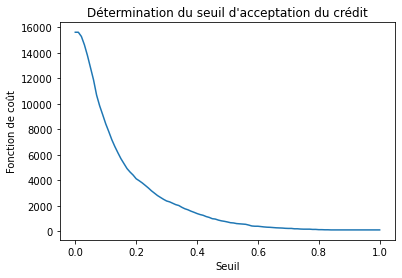

In [29]:
# On trace l'evolution des false positive. 

plt.plot(x_label,list(pb_metier))
plt.xlabel("Seuil")
plt.ylabel("Fonction de coût")
plt.title("Détermination du seuil d'acceptation du crédit")
plt.show()

In [30]:
# indice du minimum

ind_min = np.argmin(pb_metier)
x_label[ind_min]

0.84

<AxesSubplot:>

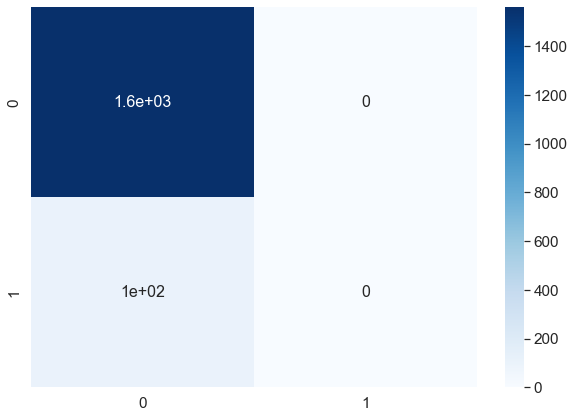

In [65]:
array = pd.DataFrame(conf_mat_thr(0.84, valid_y, y_lgbm_pred))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(array, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

## <a name="C7"> III.2 - Courbe ROC </a> 

In [31]:
# Calcul du taux de vrai positif ainsi que le taux de faux positive. 

fpr, tpr, th = roc_curve(valid_y, y_lgbm_pred)
auc_roc = roc_auc_score(valid_y, y_lgbm_pred)

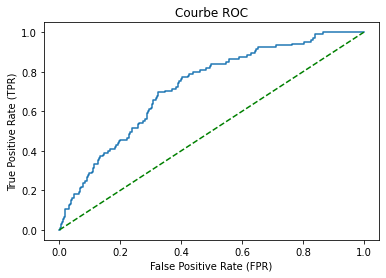

In [32]:
# Evolution du taux de faux positive en fonction du taux de vrai positive. 

plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Courbe ROC")
plt.show()

In [33]:
# On retrouve le score Auc de performance du modèle lgbm. 

print(auc_roc)

# Nous pouvons dire que le modèle est assez performant. 

0.7222171379762667


# V) Feature Importance 

## <a name="C8"> V.1 - Importance global </a> 

In [34]:
clf_lgbm = LGBMClassifier(learning_rate = 0.01, n_estimators= 1000, num_leaves= 20)
clf_lgbm.fit(train_x,train_y)

LGBMClassifier(learning_rate=0.01, n_estimators=1000, num_leaves=20)

In [35]:
shap.initjs()

explainer = shap.TreeExplainer(clf_lgbm)

In [36]:
explainer = shap.TreeExplainer(clf_lgbm)
shap_values = explainer.shap_values(train_df[feats])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


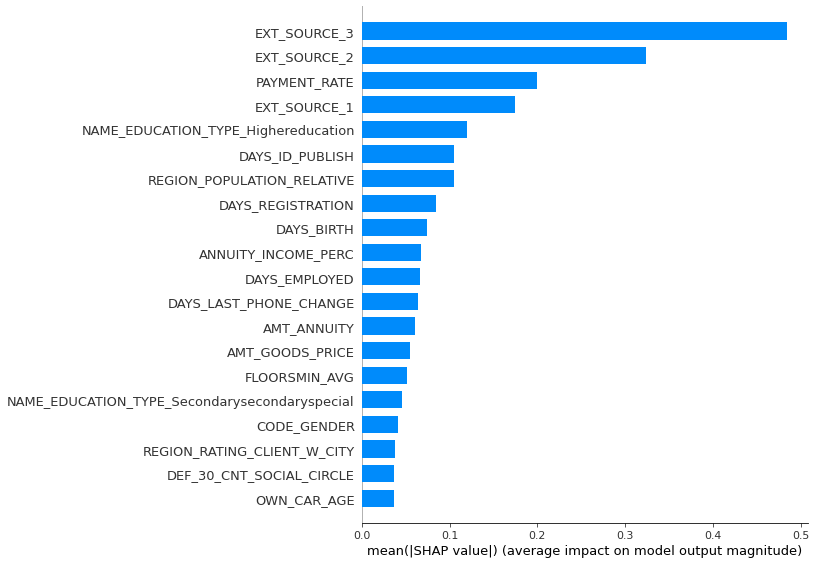

In [37]:
shap.summary_plot(shap_values[1], test_df[feats], plot_type='bar')

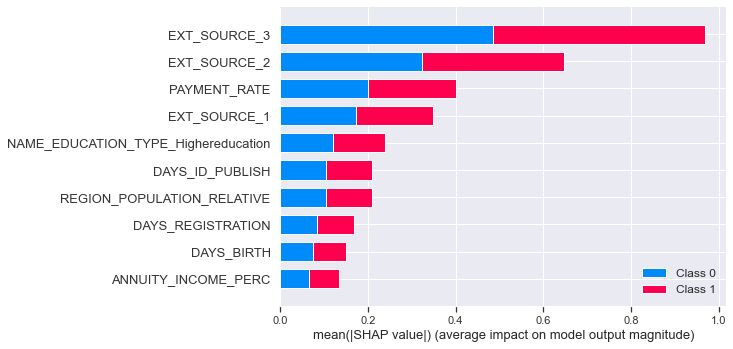

In [66]:
shap.summary_plot(shap_values, train_df[feats], max_display=10)

## <a name="C9"> V.1 - Importance local </a> 

In [39]:
shape_df = pd.DataFrame(shap_values[0])

In [40]:
shape_df.index = test_df.index
shape_df.columns = test_df[feats].columns

In [41]:
def shap_row(number):
    sort_df = shape_df.sort_values(by = [number], axis = 1)
    x = list(sort_df.loc[number])
    y = list(sort_df.columns)
    return x,y,sort_df

In [42]:
client_id = 10002

In [43]:
x, y , sort_df = shap_row(client_id)

In [44]:
def babh(x,y,n_feat,client_id):
    plt.title("feature importance du client avec l'id :"+str(client_id))
    plt.barh(y[-n_feat:], x[-n_feat:])

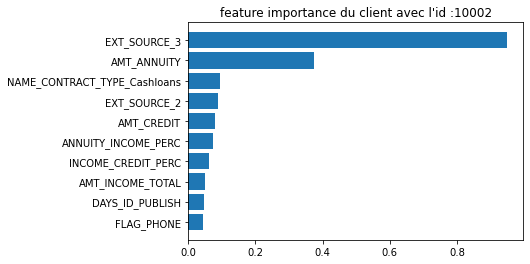

In [45]:
babh(x,y,10,client_id)

# V - API

## <a name="C10"> V.1 - Préparation des données pour l'api </a> 

In [46]:
df_desc = pd.read_csv('input/HomeCredit_columns_description.csv',encoding_errors='ignore')

In [47]:
df_desc[["Row",'Description']]

,Row,Description
0,SK_ID_CURR,ID of loan in our sample
1,TARGET,Target variable (1 - client with payment diffi...
2,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving
3,CODE_GENDER,Gender of the client
4,FLAG_OWN_CAR,Flag if the client owns a car
...,...,...
214,NUM_INSTALMENT_NUMBER,On which installment we observe payment
215,DAYS_INSTALMENT,When the installment of previous credit was su...
216,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...
217,AMT_INSTALMENT,What was the prescribed installment amount of ...


In [48]:
df_desc.to_pickle("df_desc.gz", compression={
                  'method': 'gzip', 'compresslevel': 1, 'mtime': 1})

In [49]:
joblib.dump(lgbm_pipe, "pipeline_importance.joblib")
joblib.dump(lgbm_pipe, "pipeline_credit.joblib")
joblib.dump(explainer, "shap_explainer.joblib")

['shap_explainer.joblib']

In [50]:
num_rows = 10000
df = application_train_test(num_rows)

bureau = bureau_and_balance(num_rows)
print("Bureau df shape:", bureau.shape)
df = df.join(bureau, how='left', on='SK_ID_CURR')
del bureau


prev = previous_applications(num_rows)
print("Previous applications df shape:", prev.shape)
df = df.join(prev, how='left', on='SK_ID_CURR')
del prev


pos = pos_cash(num_rows)
print("Pos-cash balance df shape:", pos.shape)
df = df.join(pos, how='left', on='SK_ID_CURR')
del pos


ins = installments_payments(num_rows)
print("Installments payments df shape:", ins.shape)
df = df.join(ins, how='left', on='SK_ID_CURR')
del ins


cc = credit_card_balance(num_rows)
print("Credit card balance df shape:", cc.shape)
df = df.join(cc, how='left', on='SK_ID_CURR')
del cc


train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.fillna(0, inplace=True)
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.fillna(0, inplace=True)
train_df = train_df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

test_df = test_df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))


f_score = dict()
lim = dict()
feats = [f for f in train_df.columns if f not in [
    'TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]
np.savetxt("feats.csv", np.atleast_2d(feats), fmt="%s", delimiter=",")


test_df.to_pickle("test_df.gz", compression={
                  'method': 'gzip', 'compresslevel': 1, 'mtime': 1})

Train samples: 10000, test samples: 10000
Bureau df shape: (2011, 108)
Previous applications df shape: (9734, 242)
Pos-cash balance df shape: (9494, 15)
Installments payments df shape: (8893, 26)
Credit card balance df shape: (9520, 131)



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [51]:
df.sort_values(by=["SK_ID_CURR"], inplace=True)
df.reset_index(drop=True, inplace=True)
df_exp = df.head(1000)
df_exp.to_pickle("df.gz", compression={'method': 'gzip', 'compresslevel': 1, 'mtime': 1})

### Références

In [52]:
# lien interessant pour comprendre les métriques --> https://kobia.fr/classification-metrics-auc-roc/

In [53]:
# --> Lien interessant concernant la précision et le rappel --> https://kobia.fr/classification-metrics-precision-recall/  